# Mean square displacement - Brownian motion from SDE

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_msd_data(filenames, timestep, t_stop, runs):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    msd_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    q_speed_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        msd_data = np.load(file=os.path.join(results_folder, filename))
        msd_matrix[i, :] = msd_data[:, 1]
        q_speed_matrix[i, :] = msd_data[:, 2]
    return times, np.mean(msd_matrix, axis=0), np.std(msd_matrix, axis=0), np.mean(q_speed_matrix, axis=0), np.std(q_speed_matrix, axis=0)

In [4]:
def log_function(t, scaling_factor):
    return np.log(t)*scaling_factor

In [5]:
def slope_function(t, scaling_factor):
    return t*scaling_factor

In [6]:
def tau_analytical(T0, xi, N, r, m=1):
    # Num and exp result China + Brilliantov and Poshel with a2=0
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return (np.sqrt(T0/m)*(1-xi**2)/6*4*np.sqrt(np.pi)*g*(2*r)**2*n)**(-1)

def D0(T0, xi, N, r, m):
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return 3*np.sqrt(T0)/((1+xi)**2*np.sqrt(m*np.pi)*n*g*(2*r)**2*2)

def gamma_1(T0, d0, m):
    return T0/(d0*m)

In [7]:
def msd_gg(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau*(np.log(1+t/tau)+(1/(tau*gamma0))*((1+t/tau)**(-tau*gamma0)-1))
    return 3*msd_1d

def msd_udsbm(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau**2*gamma0**2*(tau*np.log(1+t/tau)+(tau/(tau*gamma0-1))*((1+t/tau)**(-tau*gamma0+1)-1))/((tau*gamma0-1)**2)
    return 3*msd_1d

def msd_elasticparticles(t, d0, gamma0):
    msd_1d = 2*d0*t+2*d0*(np.exp(-gamma0*t)-1)/gamma0
    return 3*msd_1d

In [8]:
def check_convergence(times, msd_avg, msd_std, runs):
    # Error is given by Central limit theorem
    plt.figure()
    plt.loglog(times, msd_std/np.sqrt(runs))
    plt.title('Standard deviation computed from clt')
    plt.show()

## Mean square displacement from SDE

In [9]:
def plot_msd(N, xi, r, tstop, timestep, runs, save_plot=False):
    filenames = f"msd_sde_N_{N}_r_{r}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"

    print(filenames)
    print(f'---------- xi: {xi} ------------')
    
    times, msd, std_msd, mss, std_mss = read_and_return_msd_data(filenames, timestep, tstop, runs)
    
    T0 = mss[0]/3
    
    times = times[1:]
    msd = msd[1:]
    std_msd = std_msd[1:]
    mss = mss[1:]
    std_mss = std_mss[1:]
    
    check_convergence(times, msd, std_msd, runs)
    
    plt.figure()
    
    plt.loglog(times, msd, label='Numerical values')
    
    if xi == 1:
        gamma0, d0 = 11.43, 0.058  # found from 3d simulations of molecular gas with xi=1 and eta = 0.065.
        theory = msd_elasticparticles(times, d0, gamma0)
        #diff = np.abs(msd-theory)
        plt.plot(times, theory, 'k--', label='Theoretical values')
        #plt.plot(times, diff, label='|Difference|')

        print('Parameters : [D0, gamma0]')
        print('Estimated:', [d0, gamma0])
      
        popt, pcov = curve_fit(slope_function, times[-20:], msd[-20:])
        print('Slope', popt, '6d0:', 6*d0)
    else:
        d0, tau = D0(T0, xi, N, r, m=1), tau_analytical(T0, xi, N, r, m=1)
        gamma0 = gamma_1(T0, d0, m=1)
        tau = np.round(tau, decimals=2)
        gamma0 = np.round(gamma0, decimals=2)
        d0 = np.round(d0, decimals=3)
        theory = msd_udsbm(times, d0, gamma0, tau)
        #diff = np.abs(msd-theory)
        #plt.plot(times, msd_gg(times, d0, gamma0, tau), label='Theoretical values gg')
        plt.plot(times, theory, 'k--', label='Theoretical values')
        #plt.plot(times, diff, label='|Difference|')

        print('Parameters : [D0, gamma0, tau, 1/gamma0]')
        print('Estimated:', [d0, gamma0, tau, 1/gamma0])
        
        popt, pcov = curve_fit(log_function, times[-20:], msd[-20:])
        print("log const:", popt, "6d0tau", 6*tau*d0, "6d0tau^3gamma^2/(taugamma0-1)^2", 6*d0*tau**3*gamma0**2/(gamma0*tau-1)**2)
        
    
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\langle (\bm{x}(t)-\bm{x}_0)^2 \rangle$')
    # plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    if save_plot:
        plt.savefig(os.path.join(plots_folder, f'msd_sde_N_{N}_xi_{xi}_rad_{rad}_tstop_{tstop}.pdf'))
    plt.show()
    print('-----------------------')

In [10]:
def compare_dt_msd(N, xi, r, tstop, timestep_values, runs, save_plot=False):
    print(f'---------- xi: {xi} ------------')
    plt.figure()
    
    for timestep in timestep_values:
        filenames = f"msd_sde_N_{N}_r_{r}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"

        print(filenames)


        times, msd, std_msd, mss, std_mss = read_and_return_msd_data(filenames, timestep, tstop, runs)

        T0 = mss[0]/3

        times = times[1:]
        msd = msd[1:]
        std_msd = std_msd[1:]
        mss = mss[1:]
        std_mss = std_mss[1:]
        plt.loglog(times, msd, label=r'$dt={}$'.format(timestep))
    
#     if xi == 1:
#         gamma0, d0 = 11.43, 0.058  # found from 3d simulations of molecular gas with xi=1 and eta = 0.065.
#         theory = msd_elasticparticles(times, d0, gamma0)
#         plt.plot(times, theory, label='Theoretical values')
#     else:
#         d0, tau = D0(T0, xi, N, r, m=1), tau_analytical(T0, xi, N, r, m=1)
#         gamma0 = gamma_1(T0, d0, m=1)
#         tau = np.round(tau, decimals=2)
#         gamma0 = np.round(gamma0, decimals=2)
#         d0 = np.round(d0, decimals=3)
#         theory = msd_udsbm(times, d0, gamma0, tau)
#         plt.plot(times, theory, label='Theoretical values')
        
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\langle (\bm{x}(t)-\bm{x}_0)^2 \rangle$')
    # plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    if save_plot:
        plt.savefig(os.path.join(plots_folder, f"msd_sde_compare_dt_N_{N}_xi_{xi}_rad_{r}_tstop_{tstop}.pdf"))
    plt.show()
    print('-----------------------')

### Underdamped Langevin equation -> molecular gas (xi = 1)

msd_sde_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.01_X.npy
---------- xi: 1.0 ------------


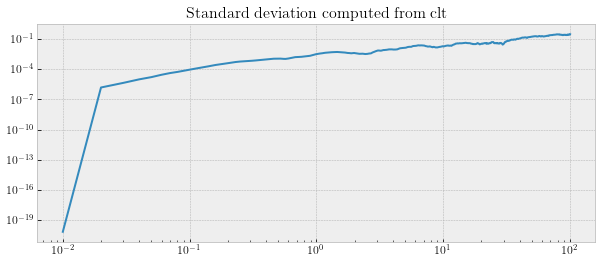

Parameters : [D0, gamma0]
Estimated: [0.058, 11.43]
Slope [0.34952698] 6d0: 0.34800000000000003


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


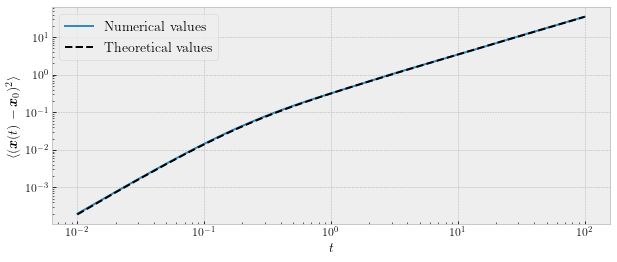

-----------------------


In [11]:
N = 1000
xi = 1.0
tstop = 100
rad = 0.025
timestep = 0.01
number_of_runs = 10

plot_msd(N, xi, rad, tstop, timestep, number_of_runs, save_plot=True)

### Underdamped Scaled Brownian motion -> granular gas (xi < 1)

msd_sde_N_1000_r_0.025_xi_0.99_tstop_100_dt_0.01_X.npy
---------- xi: 0.99 ------------


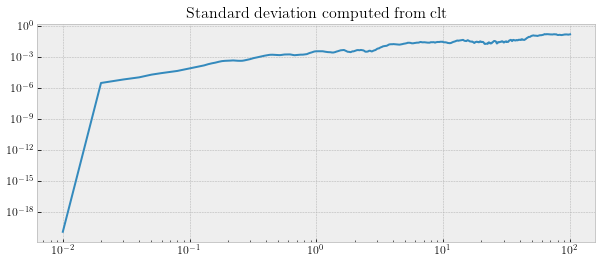

Parameters : [D0, gamma0, tau, 1/gamma0]
Estimated: [0.059, 11.32, 17.58, 0.08833922261484099]
log const: [2.58709475] 6d0tau 6.223319999999999 6d0tau^3gamma^2/(taugamma0-1)^2 6.286338773308234


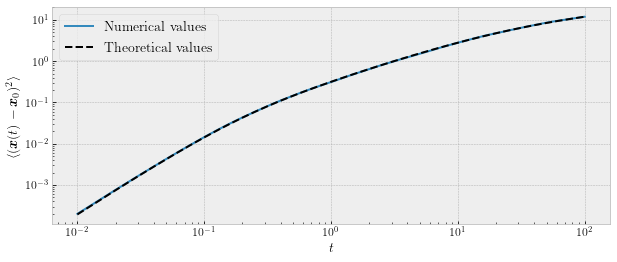

-----------------------
msd_sde_N_1000_r_0.025_xi_0.8_tstop_100_dt_0.01_X.npy
---------- xi: 0.8 ------------


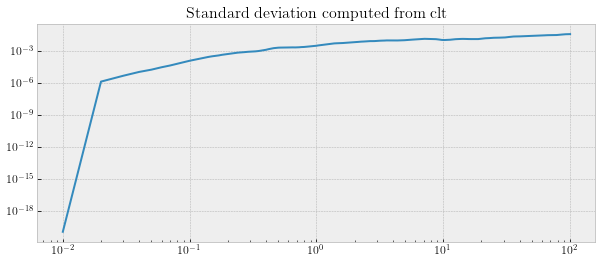

Parameters : [D0, gamma0, tau, 1/gamma0]
Estimated: [0.072, 9.26, 0.97, 0.1079913606911447]
log const: [0.51683735] 6d0tau 0.41903999999999997 6d0tau^3gamma^2/(taugamma0-1)^2 0.5306103446909369


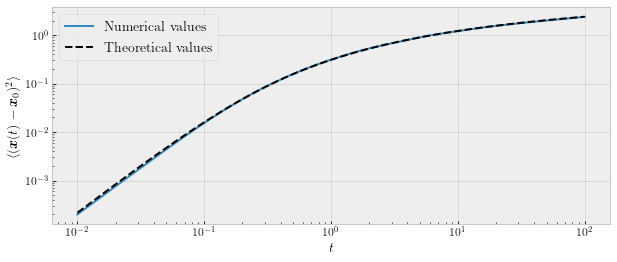

-----------------------
msd_sde_N_1000_r_0.025_xi_0.5_tstop_100_dt_0.01_X.npy
---------- xi: 0.5 ------------


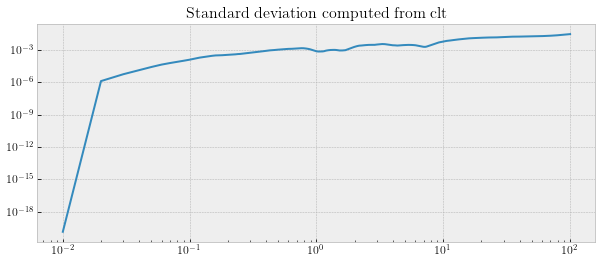

Parameters : [D0, gamma0, tau, 1/gamma0]
Estimated: [0.104, 6.43, 0.47, 0.15552099533437014]
log const: [0.69480076] 6d0tau 0.29328 6d0tau^3gamma^2/(taugamma0-1)^2 0.6550807702000361


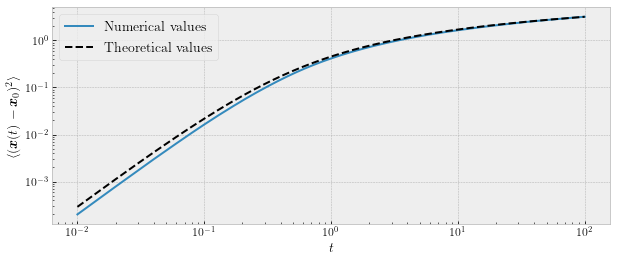

-----------------------


In [12]:
N = 1000
# xi_values = [0.99, 0.8, 0.5, 0.3]
xi_values = [0.99, 0.8, 0.5]
tstop = 100
rad = 0.025
timestep = 0.01
number_of_runs = 4

for xi in xi_values:
    plot_msd(N, xi, rad, tstop, timestep, number_of_runs, save_plot=True)

---------- xi: 0.8 ------------
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.01_X.npy
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.1_X.npy
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_1.0_X.npy


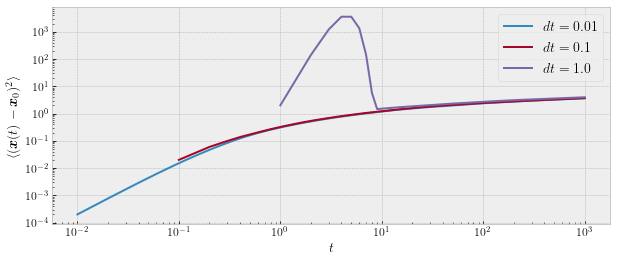

-----------------------


In [13]:
xi = 0.8
tstop = 1000
timestep_values = [0.01, 0.1, 1.0]
compare_dt_msd(N, xi, rad, tstop, timestep_values, number_of_runs, save_plot=True)

## Diffusivity

In [14]:
def compute_diffusivity(N, xi, rad, tstop, timestep, runs):
    filenames = f"msd_sde_N_{N}_r_{rad}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"
    print(filenames)
    print(f'---------- xi: {xi} ------------')
    times, msd_avg, msd_std, q_speed_avg, q_speed_std = read_and_return_msd_data(filenames, timestep, tstop, runs)
    
    T0 = q_speed_avg[0]/3
    
    # extract interesting data
    times = times[1:]
    msd_avg = msd_avg[1:]
    msd_std = msd_std[1:]
    q_speed_avg = q_speed_avg[1:]
    q_speed_std = q_speed_std[1:]
    # compute std from clt
    std_clt = msd_std/np.sqrt(runs)
    print(f'max std_clt : {max(std_clt)}')
    print('first time value', times[0], 'last time value', times[-1])
    
    d_msd = np.gradient(msd_avg, times)
    d0 = D0(T0, xi, N, rad, m=1)
    plt.figure()
    plt.loglog(times, d_msd/(6*d0), label='Numerical values')
    if xi == 1:
        plt.plot([times[0], times[-1]], [1, 1], label='Unity reference')
    else:
        tau = tau_analytical(T0, xi, N, rad, m=1)
        plt.plot(times, 1/(1+times/tau), label=r'$\frac{1}{1+t/\tau_0}$')
    plt.ylabel(r'$\frac{D(t)}{D_0}$')
    plt.xlabel(r'$t$')
    plt.legend()
    plt.show()

msd_sde_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.01_X.npy
---------- xi: 1.0 ------------
max std_clt : 0.5323112664387215
first time value 0.01 last time value 100.0


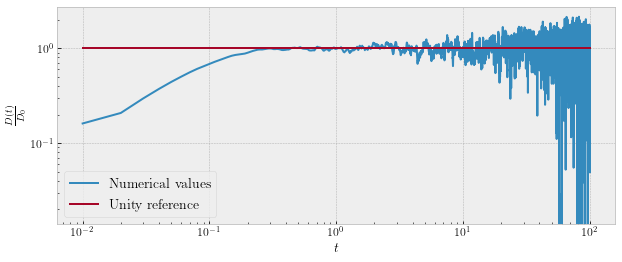

msd_sde_N_1000_r_0.025_xi_0.99_tstop_100_dt_0.01_X.npy
---------- xi: 0.99 ------------
max std_clt : 0.1544247871220719
first time value 0.01 last time value 100.0


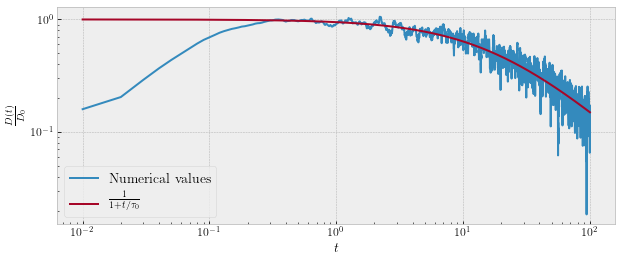

msd_sde_N_1000_r_0.025_xi_0.8_tstop_100_dt_0.01_X.npy
---------- xi: 0.8 ------------
max std_clt : 0.040730678389554575
first time value 0.01 last time value 100.0


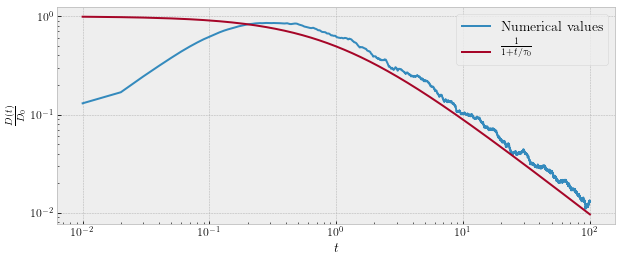

msd_sde_N_1000_r_0.025_xi_0.3_tstop_100_dt_0.01_X.npy
---------- xi: 0.3 ------------
max std_clt : 0.08203505893453106
first time value 0.01 last time value 100.0


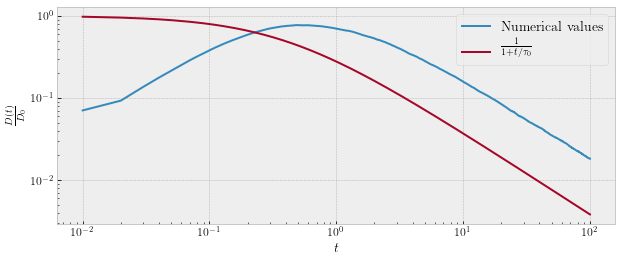

In [15]:
N = 1000
xi_values = [1.0, 0.99, 0.8, 0.3]
rad = 1/40
tstop_values = [100, 100, 100, 100]
timestep = 0.01
number_of_runs = 4

for i in range(len(xi_values)):
    xi = xi_values[i]
    tstop = tstop_values[i]
    compute_diffusivity(N, xi, rad, tstop, timestep, number_of_runs)

## HPC results

In [16]:
results_folder = results_folder.replace('results', 'results_hpc')

---------- xi: 0.8 ------------
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.01_X.npy
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.05_X.npy
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.1_X.npy


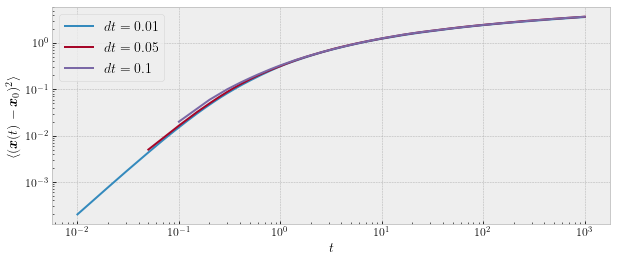

-----------------------


In [17]:
N = 1000
xi = 0.8
tstop = 1000
r = 0.025
runs = 8
timestep_values = [0.01, 0.05, 0.1]
compare_dt_msd(N, xi, rad, tstop, timestep_values, runs)

## When does UDSBM compare with a granular gas?

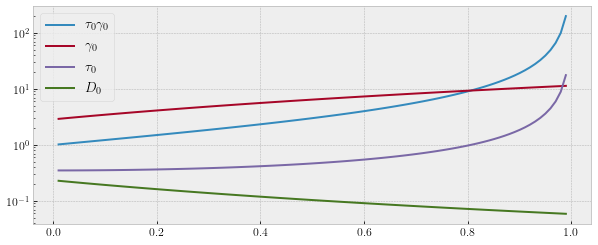

In [18]:
xi_values = np.linspace(0.01, 0.99, 100)
N = 1000
r = 0.025
T0 = 2/3
m = 1
d0_values = D0(T0, xi_values, N, r, m)
tau_values = tau_analytical(T0, xi_values, N, r, m)
gamma0_values = gamma_1(T0, d0_values, m)

plt.figure()
plt.semilogy(xi_values, gamma0_values*tau_values, label=r'$\tau_0 \gamma_0$')
plt.semilogy(xi_values, gamma0_values, label=r'$\gamma_0$')
plt.semilogy(xi_values, tau_values, label=r'$\tau_0$')
plt.semilogy(xi_values, d0_values, label=r'$D_0$')
plt.legend()
plt.show()